# SCC0287 - Mineração de Dados Não Estruturados

# Trabalho 2 - Mineração de texto

# Classificando 10 tipos diferentes de animais.

*Baseado nos códigos e conteúdos apresentados em aula.*

## Grupo:

**Alvaro Valentim P M Bandeira, Nº USP 10392150**

Bacharelado em Estatística e Ciência de Dados

email: avalentim98@usp.br

github: https://github.com/ValentAlv

**Douglas Decicino de Andrade, Nº USP 10883512**

Bacharelado em Estatística e Ciência de Dados

email: douglasdecicino@usp.br

github: https://github.com/decicino


**Renan de Oliveira da Cruz, Nº USP 10801090**

Bacharelado em Estatística e Ciência de Dados

email: r_oliveira@usp.br

github: https://github.com/nan-oliveira


Link do vídeo: https://drive.google.com/file/d/1UerpNAEkE022Q2Rf6FYr2U7GW8b88wIp/view?usp=sharing


## Importando Bibliotecas

In [1]:
import os
import matplotlib.pylab as plt
import cv2 as cv
import numpy as np
import pandas as pd
import mahotas as mt
from os import listdir
from os.path import isfile, join
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from skimage import io
import cv2
import PIL
from PIL import Image
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from keras.utils import to_categorical

# Dataset

O dataset utilizado foi o dataset Animals-10 (https://www.kaggle.com/alessiocorrado99/animals10). Ele contém cerca de 26 mil imagens de qualidade média de animais pertencentes a 10 categorias: cachorro, gato, cavalo, aranha, borboleta, galinha, ovelha, vaca, esquilo e elefante. O objetivo da mineração de imagens aqui, é utilizar diferentes etapas de pré-processamento e abordagens de extração de padrões para encontrar aquela que nos dá o melhor resultado na tarefa de classificar estes animais.

# Gerando o dataset

Criando uma função para ler as imagens do diretório e adicionar a uma lista

In [4]:
directory = 'data/'
dataset = []
for filename in os.listdir(directory):
    mypath = 'data/' + str(filename) + '/' 
    files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for img in files:
        image = io.imread(mypath+img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        dataset.append(image)

# Pré-processando via Histograma de Cores.

Vamos definir a função utilizada para gerar as features deste tipo de pré-processamento.

In [5]:
color = ('b','g','r')

dataset_hist_r = []
dataset_hist_g = []
dataset_hist_b = []

counter = 0
for image in dataset:
    hists = {}
    for i,col in enumerate(color):
        histr = cv.calcHist([image],[i],None,[256],[0,256])
        if col == 'r': dataset_hist_r.append(histr)
        if col == 'g': dataset_hist_g.append(histr)
        if col == 'b': dataset_hist_b.append(histr)


X_r = np.array(dataset_hist_r)
length = np.sqrt((X_r**2).sum(axis=1))[:,None]
X_r = X_r / length

X_g = np.array(dataset_hist_g)
length = np.sqrt((X_g**2).sum(axis=1))[:,None]
X_g = X_g / length


X_b = np.array(dataset_hist_b)
length = np.sqrt((X_b**2).sum(axis=1))[:,None]
X_b = X_b / length

Como a função criou 256 features para cada uma das 3 camadas de cor das imagens, vamos juntar esses arrays para dormar um só dataframe.

In [6]:
X = np.concatenate((X_r,X_g,X_g),axis=1)#Juntando os dados respectivos a cada camada (R,G,B)
X = X.reshape(X.shape[0],X.shape[1])
X.shape

(26179, 768)

Agora, baseado no número de imagens de cada diretório, vamos criar um vetor para a variável resposta.

In [7]:
y = ['cachorro']*4863 + ['cavalo']*2623 + ['elefante']*1446 + ['borboleta']*2112 + ['galinha']*3098  + ['gato']*1668 + ['vaca']*1866 + ['ovelha']*1820 + ['aranha']*4821 + ['esquilo']*1862
y = np.array(y)

In [8]:
df_data_hist = pd.DataFrame(X)
df_data_hist['labels'] = y
df_data_hist

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,labels
0,0.001144,0.000000,0.000000,0.000817,0.000163,0.000327,0.000817,0.000817,0.000327,0.000980,...,0.032809,0.024920,0.026534,0.012908,0.008964,0.003586,0.001614,0.000896,0.001076,cachorro
1,0.000554,0.000138,0.000092,0.000323,0.000185,0.000185,0.000462,0.000369,0.000739,0.000369,...,0.014242,0.020410,0.025717,0.038779,0.063770,0.145592,0.943308,0.220701,0.098286,cachorro
2,0.115768,0.038327,0.029664,0.025726,0.024939,0.017063,0.016801,0.019426,0.017851,0.022576,...,0.016969,0.018217,0.015472,0.021211,0.024455,0.031941,0.046415,0.045916,0.051406,cachorro
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,cachorro
4,0.000000,0.000000,0.000000,0.000543,0.000543,0.001266,0.004160,0.005969,0.015376,0.019898,...,0.000693,0.000000,0.000000,0.000520,0.000173,0.000346,0.000000,0.000173,0.000866,cachorro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26174,0.000047,0.000141,0.000047,0.000375,0.001265,0.000094,0.001733,0.000890,0.001031,0.000890,...,0.022810,0.027906,0.032858,0.071669,0.129146,0.963740,0.137623,0.062906,0.076383,esquilo
26175,0.000597,0.000199,0.000398,0.000597,0.000995,0.000597,0.000995,0.001394,0.001792,0.001394,...,0.045820,0.045013,0.050462,0.062573,0.070042,0.118486,0.313271,0.255138,0.106375,esquilo
26176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005975,0.006107,0.006771,0.007833,0.007966,0.004647,0.004780,0.003585,0.005842,esquilo
26177,0.001014,0.000870,0.000435,0.001304,0.002609,0.000435,0.005507,0.004348,0.004348,0.001014,...,0.020102,0.022267,0.028761,0.040513,0.062780,0.100974,0.170094,0.087521,0.022421,esquilo


Passando os dados para numpy array e transformando a variável resposta em numérica.

In [131]:
X_hist = np.array(df_data_hist.iloc[:,:-1])
y_hist = np.array(df_data_hist.iloc[:,-1])
le =LabelEncoder()
le.fit(list(np.unique(y_hist)))
y_hist = le.transform(y_hist)

# Pré-processando via Descritores de Texturas

Vamos definir uma função para realizar a extração das features de Haralick de uma imagem.

In [78]:
def extract_features(image):
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)
    ht_mean = textures.mean(axis=0)
    return ht_mean

Exraindo as informações de textura para cada imagem e juntando num mesmo array.

In [81]:
from tqdm.notebook import tqdm
X = []
for image in tqdm(dataset):
    textures = extract_features(image)
    X.append(textures)

  0%|          | 0/26179 [00:00<?, ?it/s]

In [82]:
df_data_hara = pd.DataFrame(X)
df_data_hara['labels'] = y
df_data_hara

,0,1,2,3,4,5,6,7,8,9,10,11,12,labels
0,0.000830,784.956154,0.919801,4872.916859,0.184383,324.314689,18706.711284,8.592383,12.834977,0.000226,5.018039,-0.326665,0.994968,cachorro
1,0.083127,616.357400,0.965514,8936.622674,0.496561,342.858839,35130.133295,6.050682,8.753159,0.000774,3.937218,-0.355729,0.986718,cachorro
2,0.000150,1902.003086,0.752640,3855.074544,0.107298,249.516241,13518.295090,8.680533,13.915585,0.000113,5.964632,-0.220170,0.973764,cachorro
3,0.000127,672.600689,0.829116,1993.353516,0.076813,240.551825,7300.813376,8.329235,13.523996,0.000105,5.505348,-0.179275,0.950538,cachorro
4,0.000159,1049.992871,0.836639,3186.987815,0.072350,220.083569,11697.958389,8.553162,13.425048,0.000134,5.373293,-0.260045,0.985344,cachorro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26174,0.019103,1477.506602,0.906594,7917.414166,0.231768,348.377447,30192.150061,7.295256,11.298704,0.000320,5.235888,-0.265885,0.981744,esquilo
26175,0.000338,516.196316,0.938537,4194.738669,0.106258,217.124431,16262.758360,8.482431,13.502337,0.000115,5.404344,-0.209615,0.975028,esquilo
26176,0.000377,211.041244,0.881225,890.457701,0.126504,239.468390,3350.789558,7.728422,12.311972,0.000187,4.754357,-0.185861,0.948745,esquilo
26177,0.000178,1382.930116,0.822088,3931.138589,0.098163,237.101806,14341.624238,8.716093,14.041514,0.000119,5.802705,-0.204668,0.955392,esquilo


In [83]:
df_data_hara.to_csv('dataset_textura.csv', index=False) #salvando dataset montado para ser utilizado outras vezes.

Passando os dados para numpy array e transformando a variável resposta em numérica.

In [133]:
X_hara = np.array(df_data_hara.iloc[:,:-1])
y_hara = np.array(df_data_hara.iloc[:,-1])

In [134]:
le = LabelEncoder()
le.fit(list(np.unique(y_hara)))
y_hara=le.transform(y_hara)

# Classificação via Histograma de Cores.

##### Vamos agora dividir o conjunto de dados com 80% de treinamento e 20% de teste (hold-out).

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_hist, y_hist, test_size=0.20, random_state=42)

## KNN

Escolhendo melhores parâmetros para o modelo.

In [178]:
model = KNeighborsClassifier()
params_KNN = {
        "n_neighbors":[3,5,7,10,15,20,25,30,50,80,100,500,1000],
        "weights":['uniform','distance'],
        "metric": ['euclidean','manhattan','minkowski','chebyshev'],
    } 
grid_search_cv = RandomizedSearchCV(model, params_KNN, cv=10, scoring="accuracy")
# Achando os melhores hiperparâmetros
result = grid_search_cv.fit(X_train, y_train)
best_model = result.best_estimator_
best_model

KNeighborsClassifier(metric='manhattan', n_neighbors=100, weights='distance')

#### OBS: utilizando o parâmetro _weights='distance'_, estamos adotando uma abordagem que visa diminuir o efeito do desbalanceamento de classe.

Ajustando o modelo.

In [179]:
model = KNeighborsClassifier(n_neighbors=100, metric = 'manhattan',weights='distance')
model.fit(X_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(X_test) 

Resultado

In [180]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.25611153552330024


## Random Forest

Escolhendo melhores parâmetros para o modelo.

In [214]:
model_RF = RandomForestClassifier()
params_RF = {'n_estimators': [50, 150, 250],
            'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
            'min_samples_split': [2, 4, 6],
            'class_weight': [None, 'balanced']}
grid_search_cv = RandomizedSearchCV(model_RF, params_RF, cv=5, scoring="accuracy",n_jobs = 8)
# Achando os melhores hiperparâmetros
result = grid_search_cv.fit(X_train, y_train)
best_model = result.best_estimator_
best_model

RandomForestClassifier(max_features=0.5, n_estimators=250)

In [215]:
model = RandomForestClassifier(n_estimators=250, max_features = 0.5)
model.fit(X_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(X_test) 

In [216]:
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.3737585943468296


# Classificação via Descritores de Texturas.

##### Vamos agora dividir o conjunto de dados com 80% de treinamento e 20% de teste (hold-out).

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_hara, y_hara, test_size=0.20, random_state=42)

## KNN

Escolhendo melhores parâmetros para o modelo.

In [189]:
model = KNeighborsClassifier()
params_KNN = {
        "n_neighbors":[3,5,7,10,15,20,25,30,50,80,100,500,1000],
        "weights":['uniform','distance'],
        "metric": ['euclidean','manhattan','minkowski','chebyshev'],
    } 
grid_search_cv = RandomizedSearchCV(model, params_KNN, cv=10, scoring="f1_micro",n_jobs = 4)
# Achando os melhores hiperparâmetros
result = grid_search_cv.fit(X_train, y_train)
best_model = result.best_estimator_
best_model

KNeighborsClassifier(metric='manhattan', n_neighbors=50, weights='distance')

#### OBS: utilizando o parâmetro _weights='distance'_, estamos adotando uma abordagem que visa diminuir o efeito do desbalanceamento de classe.

In [193]:
model = KNeighborsClassifier(n_neighbors=50, metric = 'manhattan',weights='distance',n_jobs = 4)
model.fit(X_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(X_test) 

In [194]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.2614591291061879


## Random Forest

Escolhendo melhores parâmetros para o modelo.

In [210]:
model_RF = RandomForestClassifier()
params_RF = {'n_estimators': [50, 150, 250],
            'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
            'min_samples_split': [2, 4, 6],
            'class_weight': [None, 'balanced']}
grid_search_cv = RandomizedSearchCV(model_RF, params_RF, cv=5, scoring="accuracy",n_jobs = 8)
# Achando os melhores hiperparâmetros
result = grid_search_cv.fit(X_train, y_train)
best_model = result.best_estimator_
best_model

RandomForestClassifier(max_features=0.75, min_samples_split=4, n_estimators=150)

In [211]:
model = RandomForestClassifier(n_estimators=150, max_features = 0.75, min_samples_split=4)
model.fit(X_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(X_test) 

In [212]:
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.37203972498090143


Vemos que, para as duas abordagens, o classificador Random Forest se saiu consideravelmente melhor que o KNN, e o tipo de pré-processamento utilizado não alterou significativamente a acurácia do classificador.

# Classificação via CNN.

Vamos primeiramente rescalar nossas imagens para que todas tenham o mesmo tamanho, para que possamos utilizar na CNN.

In [5]:
directory = 'data/'
image_list = []
resized_images=[]
for filename in os.listdir(directory):
    mypath = 'data/' + str(filename) + '/' 
    files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for img in files:
        image = Image.open(mypath+img).resize((250,250))
        image = np.array(image)
        resized_images.append(image)
X = np.array(resized_images)
del(resized_images)

In [6]:
y = ['cachorro']*4863 + ['cavalo']*2623 + ['elefante']*1436 + ['borboleta']*2073 + ['galinha']*3098  + ['gato']*1667 + ['vaca']*1866 + ['ovelha']*1820 + ['aranha']*4820 + ['esquilo']*1862
y = np.array(y)
le =LabelEncoder()
le.fit(list(np.unique(y)))
y = le.transform(y)

##### Vamos agora dividir o conjunto de dados com 80% de treinamento e 20% de teste (hold-out).

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [7]:
X_train = np.float16(X_train)
X_test = np.float16(X_test)
X_train = X_train/255
X_test = X_test/255

In [15]:
#Checando se os dados foram normalizados.
(X_train.min(),X_train.max(),X_train.min(),X_train.max(),X_test.min(),X_test.max(),X_test.min(),X_test.max())

(0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

In [17]:
print('O número de linhas das imagens é: ', X_train.shape[1], '\n O número de colunas das imagens é: ', X_train.shape[2] ,'\n O número de canais  das é: ',X_train.shape[3] )

O número de linhas das imagens é:  250 
 O número de colunas das imagens é:  250 
 O número de canais  das é:  3


In [9]:
#Quantidade de imagens de treino e teste
print("A quantidade de imagens para ao conjunto de treino da base é: ", y_train.shape[0])
print("A quantidade de imagens para ao conjunto de teste da base é: ", y_test.shape[0])

A quantidade de imagens para ao conjunto de treino da base é:  20902
A quantidade de imagens para ao conjunto de teste da base é:  5226


In [27]:
y_train_pd = pd.Series(y_train)
y_test_pd = pd.Series(y_test)

Vamos avaliar se as proporções entre as classes da variável resposta ficaram iguais para a base de treino e base de teste.

<AxesSubplot:ylabel='count'>

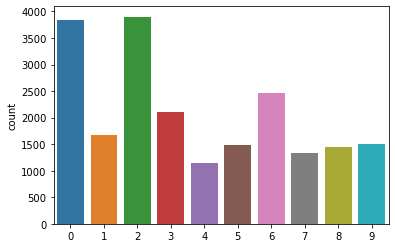

In [16]:
sns.countplot(x=y_train)

<AxesSubplot:ylabel='count'>

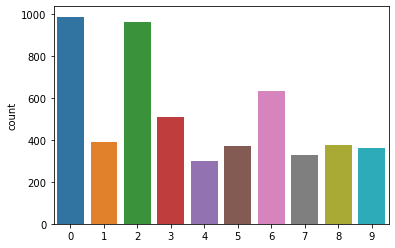

In [15]:
sns.countplot(x=y_test)

Exemplo de imagem para cada classe

Text(0.5, 1.0, 'Esquilo')

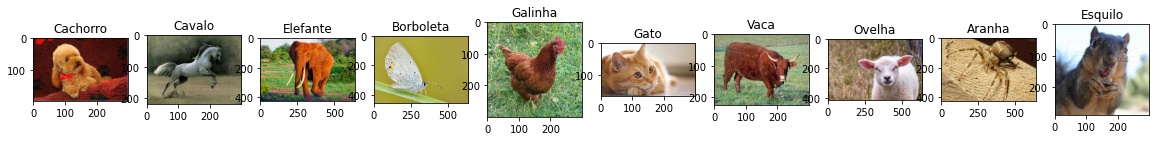

In [88]:
# create figure
fig = plt.figure(figsize=(20, 10))

# setting values to rows and column variables
rows = 1
columns = 10

# reading images
Image1 = io.imread('data/cane/OIP-__Yu1XH3iAC10OzGQFpC-AHaE8.jpeg')
Image2 = io.imread('data/cavallo/OIP-_4xQfMZofBLJHN-EjvNIbAHaFa.jpeg')
Image3 = io.imread('data/elefante/e83cb60828f5043ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg')
Image4 = io.imread('data/farfalla/e030b20929e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg')
Image5 = io.imread('data/gallina/28.jpeg')
Image6 = io.imread('data/gatto/2.jpeg')
Image7 = io.imread('data/mucca/OIP-_1Zlq8IuJjORr6HhIGetCQHaFj.jpeg')
Image8 = io.imread('data/pecora/e830b1072ef6043ed1584d05fb1d4e9fe777ead218ac104497f5c978a6ebb3bf_640.jpg')
Image9 = io.imread('data/ragno/e83db80628f01c22d2524518b7444f92e37fe5d404b0144390f8c47ba6edbc_640.jpg')
Image10 = io.imread('data/scoiattolo/OIP-_LQ_PTWmYyR9N_fPk5W49AHaHF.jpeg')


fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.title("Cachorro")
fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.title("Cavalo")
fig.add_subplot(rows, columns, 3)
plt.imshow(Image3)
plt.title("Elefante")
fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.title("Borboleta")
fig.add_subplot(rows, columns, 5)  
plt.imshow(Image5)
plt.title("Galinha")
fig.add_subplot(rows, columns, 6)
plt.imshow(Image6)
plt.title("Gato")
fig.add_subplot(rows, columns, 7)
plt.imshow(Image7)
plt.title("Vaca")
fig.add_subplot(rows, columns, 8)
plt.imshow(Image8)
plt.title("Ovelha")
fig.add_subplot(rows, columns, 9)
plt.imshow(Image9)
plt.title("Aranha")
fig.add_subplot(rows, columns, 10)
plt.imshow(Image10)
plt.title("Esquilo")

### Agora, vamos criar e compilar o modelo de Rede Neural Convolucional

In [30]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(250,250,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(250,250,3), padding='same'))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(250,250,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(250,250,3), padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(250,250,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 62, 32)       

In [32]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [43]:
#Passando o vetor da variável target para a forma que o Keras aceita
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)

Treinando o modelo

In [35]:
model.fit(
    X_train, y_train2,    
    epochs=10,
    verbose=1,
    batch_size=20)

Epoch 1/10
1046/1046 [==============================] - 323s 309ms/step - loss: 1.5238 - accuracy: 0.4790
Epoch 2/10
1046/1046 [==============================] - 332s 317ms/step - loss: 1.0881 - accuracy: 0.6379
Epoch 3/10
1046/1046 [==============================] - 331s 317ms/step - loss: 0.7336 - accuracy: 0.7546
Epoch 4/10
1046/1046 [==============================] - 322s 308ms/step - loss: 0.4038 - accuracy: 0.8664
Epoch 5/10
1046/1046 [==============================] - 322s 308ms/step - loss: 0.2128 - accuracy: 0.9305
Epoch 6/10
1046/1046 [==============================] - 322s 308ms/step - loss: 0.1440 - accuracy: 0.9517
Epoch 7/10
1046/1046 [==============================] - 323s 309ms/step - loss: 0.1095 - accuracy: 0.9652
Epoch 8/10
1046/1046 [==============================] - 326s 311ms/step - loss: 0.0974 - accuracy: 0.9679
Epoch 9/10
1046/1046 [==============================] - 327s 313ms/step - loss: 0.0938 - accuracy: 0.9697
Epoch 10/10
1046/1046 [=======================

In [36]:
#Salvando o modelo para utilizar posteriormente
model.save('CNN')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN\assets


Vamos agora ver como o modelo se saiu no conjunto de teste

In [ ]:
#Carregando o modelo já treinando anteriormente
model = keras.models.load_model('CNN')

In [44]:
model.evaluate(X_test, y_test2)

164/164 [==============================] - 17s 106ms/step - loss: 1133.9125 - accuracy: 0.4049


[1133.9124755859375, 0.40489858388900757]

### Conclusões

Utilizando como pré processamento o histograma de cores e as texturas de Haralick e como extração de padrões os modelos de KNN e Random Forest, para ambos os tipos de pré processamento, os resultados utilizando os dois modelos foram muito parecidos, sendo o Random Forest o que se saiu melhor entre os dois, com uma acurácia de cerca de **0.37**.

Já utilizando a rede neural convolucional, temos uma acurácia um pouco maior, de **0.40**, sendo este, o modelo que se saiu melhor dentre os testados anteriormente.

Em diversas situações informações numéricas, categóricas nominais ou ordinais ou até mesmo textos são dados de relevada importância. Ressalta-se ainda que em determinados momentos essas informações não são as únicas que podem ser utilizadas para descrever, prescrever ou predizer sobre questões do mundo.

Imagens estão presentes em toda parte e representam informações cruciais para descrever o mundo. Elas são de grande importância e podem contribuir tanto para a identificação de um artista e em qual vertente da história da arte ele mais se adéqua quanto podem auxiliar na definição de doenças pulmonares, por exemplo.

Em razão do exposto fica nítido a importância de imagens dentro da área de data science. Essa forma de dado armazena um tipo de informação que até um tempo atrás não era utilizado. De posse dessa informação podemos desde descobrir um "primo" de Picasso até mesmo identificar se alguém tem alguma síndrome respiratória. No nosso caso, uma possível aplicação poderia ser uma implementação de um modelo que identifica animais em uma espécie de robô ou drone para ajudar no controle do número de animais de uma fazenda, por exemplo.